In [14]:
#| include: false
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
cd(@__DIR__)
# Pkg.add("PyCall")
# Pkg.add("Conda")
# Pkg.add("Graphs")
# Pkg.add("CairoMakie")
# Pkg.add("GraphMakie")
# Pkg.add("JSON3")
# Pkg.add("ColorSchemes")
# Conda.pip("install", "google-api-python-client")

  Activating project at `~/gitrepos/kdheepak.github.io/blog/graphing-cgpgrey-rock-paper-scissors-youtube-game`


If you haven't already checked it out, go watch CGPGrey's Rock-Paper-Scissors YouTube Game.

{{< video https://www.youtube.com/watch?v=PmWQmZXYd74 >}}

In this post, I'm going to explore what all the possible paths available are.
Let's import some packages first.

In [15]:
#| output: false
using PyCall
using Conda
using Graphs
using WGLMakie
using CairoMakie
using GraphMakie
using GraphMakie.NetworkLayout
using JSON3
using JSServe, Markdown
using ColorSchemes
Page(exportable=true, offline=true)
WGLMakie.activate!()
Makie.inline!(true)

true

Fortunately for us, CGPGrey was kind enough to put links to the choices in the
description of (_almost_) every video.
We can use Google's YouTube API to get the video descriptions and get all the YouTube
links in the description.

We are going to use the `google-api-python-client` in Python from Julia.

In [16]:
#| code-fold: true
#| output: false
API_KEY = ENV["YOUTUBE_API_KEY"]; # Get API_KEY from google console
build = pyimport("googleapiclient.discovery").build # from googleapiclient.discovery import build
youtube = build("youtube", "v3", developerKey=API_KEY) # call build function in Python

PyObject <googleapiclient.discovery.Resource object at 0x368db6160>

Now we can get the description of every video, extract the metadata from it into a `Dict` of `Dict`s, build a graph:

In [17]:
#| code-fold: true
#| output: false
youtubeid(url) = string(first(split(replace(url, "https://www.youtube.com/watch?v=" => ""), "&t")))

function metadata(url)
  id = youtubeid(url)
  request = youtube.videos().list(part=["snippet", "statistics"], id=id)
  response = request.execute()
  description = response["items"][1]["snippet"]["description"]
  title = response["items"][1]["snippet"]["title"]
  views = parse(Int, response["items"][1]["statistics"]["viewCount"])
  if url == "https://www.youtube.com/watch?v=CPb168NUwGc"
    # Special case for https://www.youtube.com/watch?v=CPb168NUwGc (description for this is not standard)
    return (; description="""
WIN: https://www.youtube.com/watch?v=RVLUX6BUEJI
LOSE / DRAW: https://www.youtube.com/watch?v=jDQqv3zkbIQ

🌐 Website: https://www.cgpgrey.com
💖 Patreon: https://www.patreon.com/cgpgrey
📒 Cortex: http://www.cortexbrand.com

⛔️ Ah01F ✅
""", title="🔴", views)
  end
  (; description, title, views)
end

function links(url; visited=Dict(), duplicate_links=false)
  m = metadata(url)
  r = Dict(
    :id => youtubeid(url),
    :code => last(split(strip(m.description), "\n")), # last line is a special code
    :url => url,
    :links => [],
    :children => [],
    :title => m.title,
    :views => m.views,
  )
  for line in split(m.description, "\n")
    if occursin("https://www.youtube.com/watch?v=", line)
      _status, video = split(line, ":", limit=2)
      video = strip(video)
      push!(r[:links], Dict(:status => string(_status), :url => string(video)))
    end
  end

  for link in r[:links]
    url = link[:url]
    if !(url in keys(visited))
      visited[url] = Dict()
      s = links(url; visited, duplicate_links)
      push!(r[:children], s)
      visited[url] = s
    else
      duplicate_links && push!(r[:children], visited[url])
    end
  end
  return r
end

function cached_links(url; duplicate_links)
  bfile = """$(youtubeid(url))-$(duplicate_links ? "dup-links" : "no-dup-links").json"""
  if isfile(bfile)
    return JSON3.read(bfile)
  end
  r = links(url; duplicate_links)
  open(bfile, "w") do f
    JSON3.write(f, r)
  end
  r
end

function _clean_titles(str)
  t = join([c for c in str if isascii(c)])
  t = strip(t)
  if occursin("Cortex", t)
    return ""
  end
  string(t)
end


function _node_builder(nodes, d)
  for c in d[:children]
    push!(nodes, (; id=c[:id], title=_clean_titles(c[:code]), url=c[:url], views=c[:views]))
    _node_builder(nodes, c)
  end
end

function _graph_builder(G, d, ids)
  from = d[:id]
  for c in d[:children]
    to = c[:id]
    add_edge!(G, findfirst(isequal(from), ids), findfirst(isequal(to), ids))
    _graph_builder(G, c, ids)
  end
end

function get_nodes(data)
  nodes = [(; id=data[:id], title=_clean_titles(data[:title]), url=data[:url], views=data[:views])]
  _node_builder(nodes, data)
  nodes = unique(nodes)
  ids = [n.id for n in nodes]
  titles = [n.title for n in nodes]
  urls = [n.url for n in nodes]
  (; ids, titles, urls, nodes)
end

function grapher(data, ids)
  G = SimpleDiGraph(length(ids))
  _graph_builder(G, data, ids)
  G
end

grapher (generic function with 1 method)

In [18]:
#| code-fold: false
data = cached_links("https://www.youtube.com/watch?v=PmWQmZXYd74", duplicate_links=true)
(; ids, titles, urls, nodes) = get_nodes(data)
G = grapher(data, ids)

{111, 206} directed simple Int64 graph

In [19]:
#| echo: false
using Markdown
display(md"There's **$(nv(G))** videos in this graph with **$(ne(G))** connections between the videos.")

There's **111** videos in this graph with **206** connections between the videos.


Here's what that graph visualized looks like:

In [20]:
#| code-fold: true
WGLMakie.activate!()
set_theme!(; size=(800, 800), fonts=(; title="CMU Serif"))
views = [node[:views] for node in nodes]
min_val, max_val = extrema(views[2:end])
normed_views = (views .- min_val) ./ (max_val - min_val)
colors = cgrad(:viridis, scale=log)
node_colors = ColorSchemes.get.(Ref(colors), normed_views)

f, ax, p = graphplot(G;
  nlabels=titles,
  nlabels_fontsize=10,
  node_color=node_colors,
  node_size=20,
  arrow_size=8,
  layout=Stress(dim=3)
)
Colorbar(f[1, 2], limits=extrema(views), colormap=colors, label="YouTube Views")
# hidedecorations!(ax); hidespines!(ax);
# offsets = [Point2f(0.1, -0.5) for _ in p[:node_pos][]]
# offsets[1] = Point2f(0.1, 0.5)
# p.nlabels_offset[] = offsets
# autolimits!(ax)
# ax.title = "CGP Grey's Rock-Paper-Scissors YouTube Game"
f

You can click and drag to rotate and use the mouse wheel to zoom in the above plot.

This graph contains a lot of duplicate links to the same video.
For example when losing after different number of wins, you might end up at the same video.
Let's remove those connections so we can visualize it as a tree.

In [8]:
#| code-fold: true
data = cached_links("https://www.youtube.com/watch?v=PmWQmZXYd74", duplicate_links=false)
(; ids, titles, urls, nodes) = get_nodes(data)
G = grapher(data, ids)

{111, 110} directed simple Int64 graph

In [9]:
#| echo: false
using Markdown
display(md"There's **$(nv(G))** videos in this graph with **$(ne(G))** connections between the videos.")

There's **111** videos in this graph with **110** connections between the videos.


Here's what the graph now visualized looks like:

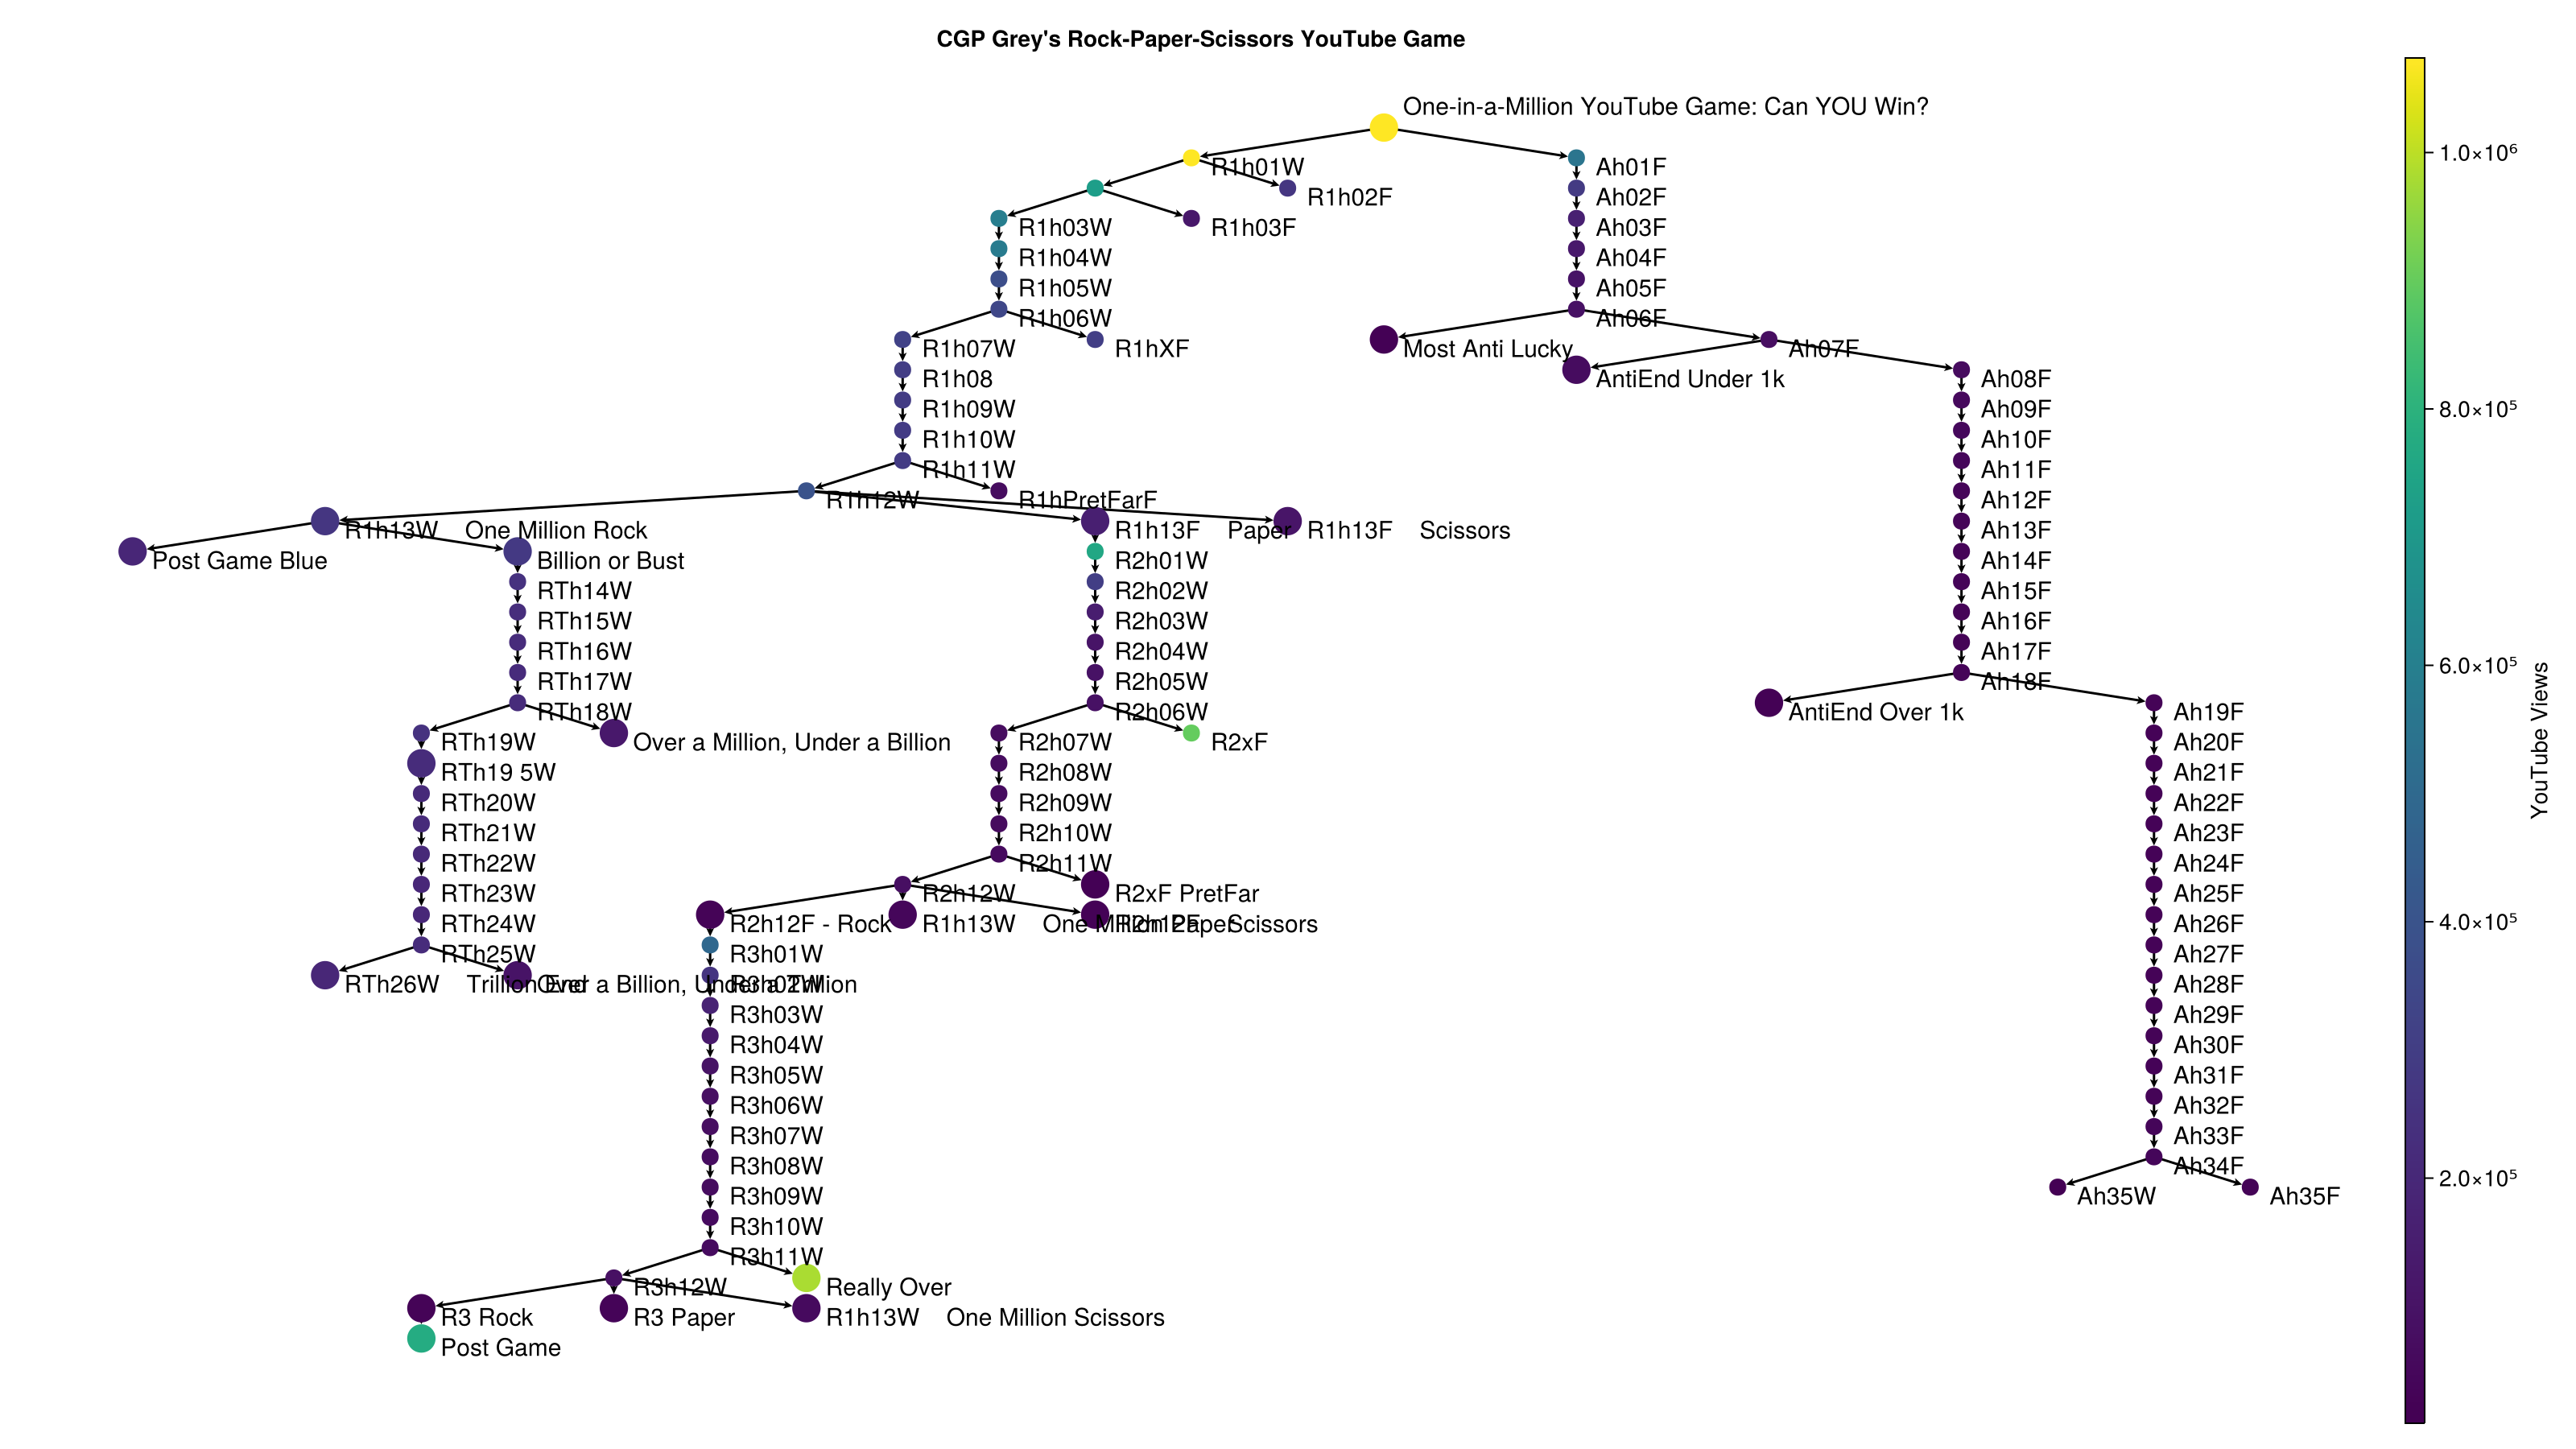

In [10]:
#| code-fold: true
CairoMakie.activate!()
set_theme!(; size=(1600, 900), fonts=(; title="CMU Serif"))

views = [node[:views] for node in nodes]
min_val, max_val = extrema(views[2:end])
normed_views = (views .- min_val) ./ (max_val - min_val)
colors = cgrad(:viridis, scale=log)
node_colors = ColorSchemes.get.(Ref(colors), normed_views)

# If there's a space it is probably a unique name
node_size = [length(split(strip(t))) > 1 ? 25 : 15 for t in titles]

f, ax, p = graphplot(G;
  nlabels=titles,
  nlabels_fontsize=15,
  node_color=node_colors,
  node_size,
  arrow_size=8,
  arrow_shift=:end,
  layout=Buchheim()
)
hidedecorations!(ax);
hidespines!(ax);
offsets = [Point2f(0.1, -1.5) for _ in p[:node_pos][]]
offsets[1] = Point2f(0.1, 0.5)
p.nlabels_offset[] = offsets
autolimits!(ax)
ax.title = "CGP Grey's Rock-Paper-Scissors YouTube Game"
Colorbar(f[1, 2], limits=extrema(views), colormap=colors, label="YouTube Views")
f

There we have it; a flowchart of the Rock-Paper-Scissors game.

Here's a table that contains the sorted view count as of April 19th, 2024.

In [11]:
#| code-fold: true
import DataFrames as DF

# Create an empty DataFrame
df = DF.DataFrame(Title=String[], Views=Int[])

for idx in sortperm(views, rev=true)
  push!(df, (; Title=titles[idx], Views=views[idx]))
end

# Display the DataFrame
display(df)

111×2 DataFrame
 Row │ Title                              Views   
     │ String                             Int64   
─────┼────────────────────────────────────────────
   1 │ One-in-a-Million YouTube Game: C…  1073774
   2 │ R1h01W                              420943
   3 │ Really Over                         386865
   4 │ R2xF                                354432
   5 │ Post Game                           306757
   6 │ R2h01W                              299879
   7 │                                     285998
   8 │ R1h03W                              234144
   9 │ R1h04W                              228726
  10 │ Ah01F                               218414
  11 │ R3h01W                              195832
  ⋮  │                 ⋮                     ⋮
 102 │ Ah24F                                14309
 103 │ Ah27F                                14286
 104 │ Ah28F                                14184
 105 │ Ah26F                                14115
 106 │ Ah25F                                14112
 107 │ R2h12F    Scissors                   12105
 108 │ AntiEnd Over 1k                      11331
 109 │ R2xF PretFar                         10516
 110 │ Most Anti Lucky                      10395
 111 │ Ah35W                                 8809
                                   90 rows omitted

If you liked this blog post, consider subscribing to
[CGP Grey's Patreon](https://www.patreon.com/cgpgrey)
so that they can make more awesome content like this.

If you are interested in viewing all the videos, you can check them out below:

In [12]:
#| code-fold: true
using IJulia

function display_youtube_video(node)
  video_id = split(node.url, "=")[end]
  title = node.title
  if isempty(title)
    title = "---no special code---"
  end
  html_code = """
<details>
  <summary>$(title)</summary>
  <iframe width="560" height="315" src="https://www.youtube.com/embed/$video_id" frameborder="0" allowfullscreen></iframe>
</details>
  """
  display("text/html", HTML(html_code))
end

@assert unique(nodes) == nodes

display_youtube_video.(nodes);

One-in-a-Million YouTube Game: Can YOU Win?

R1h01W

---no special code---

R1h03W

R1h04W

R1h05W

R1h06W

R1h07W

R1h08

R1h09W

R1h10W

R1h11W

R1h12W

R1h13W One Million Rock

Post Game Blue

Billion or Bust

RTh14W

RTh15W

RTh16W

RTh17W

RTh18W

RTh19W

RTh19 5W

RTh20W

RTh21W

RTh22W

RTh23W

RTh24W

RTh25W

RTh26W Trillion End

Over a Billion, Under a Trillion

Over a Million, Under a Billion

R1h13F Paper

R2h01W

R2h02W

R2h03W

R2h04W

R2h05W

R2h06W

R2h07W

R2h08W

R2h09W

R2h10W

R2h11W

R2h12W

R2h12F - Rock

R3h01W

R3h02W

R3h03W

R3h04W

R3h05W

R3h06W

R3h07W

R3h08W

R3h09W

R3h10W

R3h11W

R3h12W

R3 Rock

Post Game

R3 Paper

R1h13W One Million Scissors

Really Over

R1h13W One Million Paper

R2h12F Scissors

R2xF PretFar

R2xF

R1h13F Scissors

R1hPretFarF

R1hXF

R1h03F

R1h02F

Ah01F

Ah02F

Ah03F

Ah04F

Ah05F

Ah06F

Most Anti Lucky

Ah07F

AntiEnd Under 1k

Ah08F

Ah09F

Ah10F

Ah11F

Ah12F

Ah13F

Ah14F

Ah15F

Ah16F

Ah17F

Ah18F

AntiEnd Over 1k

Ah19F

Ah20F

Ah21F

Ah22F

Ah23F

Ah24F

Ah25F

Ah26F

Ah27F

Ah28F

Ah29F

Ah30F

Ah31F

Ah32F

Ah33F

Ah34F

Ah35W

Ah35F